In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import holidays

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss

# import xgboost as xgb
# from xgboost import XGBRegressor, plot_tree
# import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

# = = = = = =
# own stuff

os.chdir("C:/Users/ytl_c/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/2023_11-PTSFC")
from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [2]:
df_energy = get_energy_data_today(to_date="20231201")
print(df_energy.info())
df_energy.tail(5)

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78168 entries, 2014-12-31 23:00:00+00:00 to 2023-12-01 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78168 non-null  datetime64[ns, CET]
 1   gesamt         78168 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75


In [3]:
import os as os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]

In [4]:
df_energy_dummy = create_dummy_df(df_energy, hour_method='simple')
df_energy_fturs = create_features_df(df_energy_dummy)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start = '2022-01-01'
end = '2023-06-01'
df_energy_dummy_small = df_energy_dummy.loc[(df_energy_dummy['timestamp_CET'] > start) & 
                                            (df_energy_dummy['timestamp_CET'] <= end)]
df_energy_fturs_small = df_energy_fturs.loc[(df_energy_fturs['timestamp_CET'] > start) & 
                                            (df_energy_fturs['timestamp_CET'] <= end)]

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =                                       
# time series train test split

# use sklearn TimeSeriesSplit to genrate ...
    # X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy
    # X_train_fturs, X_test_fturs, y_train_fturs, y_test_fturs

X = df_energy_fturs_small.drop(['gesamt', 'timestamp_CET'], axis=1)
y = df_energy_fturs_small['gesamt']

tscv = TimeSeriesSplit(n_splits=2, test_size=100)
for train_index, test_index in tscv.split(X):
    X_train_fturs, X_test_fturs = X.iloc[train_index], X.iloc[test_index]
    y_train_fturs, y_test_fturs = y.iloc[train_index], y.iloc[test_index]

X = df_energy_dummy_small.drop(['gesamt', 'timestamp_CET'], axis=1)
y = df_energy_dummy_small['gesamt']

for train_index, test_index in tscv.split(X):
    X_train_dummy, X_test_dummy = X.iloc[train_index], X.iloc[test_index]
    y_train_dummy, y_test_dummy = y.iloc[train_index], y.iloc[test_index]

# [TODO cross validation

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train quantile models ... regression and gradient boosting

# - - - - - - - - - -
# quantile regression with dummies

all_models_quant_reg = {}
for alpha in quantiles_arr:
    quantile_regressor = QuantileRegressor(alpha=alpha, solver='highs')
    all_models_quant_reg["q %1.2f" % alpha] = quantile_regressor.fit(X_train_dummy, y_train_dummy)

# - - - - - - - - - -
# gradient boosting with features

common_params = dict(
    learning_rate=0.05,
    max_depth=2,
    min_samples_leaf=9,
)

all_models_grad_boost = {}
for alpha in quantiles_arr:

    # Use the QuantileRegressor for faster training on small to medium datasets n < 10_000
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)

    # Use the HistGradientBoostingRegressor for faster training on large datasets n > 10_000
    # gbr = HistGradientBoostingRegressor(loss='quantile', quantile=alpha, **common_params)

    all_models_grad_boost["q %1.2f" % alpha] = gbr.fit(X_train_fturs, y_train_fturs)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# evaluation on test set
    
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

# Evaluation for Quantile Regression
results_quant_reg = []
for name, quant_reg_model in sorted(all_models_quant_reg.items()):

    metrics = {"model": name}
    y_pred_quant_reg = quant_reg_model.predict(X_test_dummy)

    for alpha in quantiles_arr:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_test_dummy, y_pred_quant_reg, alpha=alpha)

    metrics["MSE"] = mean_squared_error(y_test_dummy, y_pred_quant_reg)
    results_quant_reg.append(metrics)

# Evaluation for Gradient Boosting
results_grad_boost = []
for name, grad_boost_model in sorted(all_models_grad_boost.items()):

    metrics = {"model": name}
    y_pred_grad_boost = grad_boost_model.predict(X_test_fturs)

    for alpha in quantiles_arr:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_test_fturs, y_pred_grad_boost, alpha=alpha)
        
    metrics["MSE"] = mean_squared_error(y_test_fturs, y_pred_grad_boost)
    results_grad_boost.append(metrics)

In [5]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# print error metrics MAE, MSE, Pinball Loss

df_results_quant_reg = pd.DataFrame(results_quant_reg).set_index("model")
df_results_quant_reg.style.apply(highlight_min)

,pbl=0.03,pbl=0.25,pbl=0.50,pbl=0.75,pbl=0.97,MSE
model,,,,,,
q 0.03,10591.502750,8174.172500,5488.250000,2802.327500,384.997250,174521394.128750
q 0.25,10858.891875,8458.698750,5791.817500,3124.936250,724.743125,187524189.196250
q 0.50,10858.891875,8458.698750,5791.817500,3124.936250,724.743125,187524189.196250
q 0.75,10858.891875,8458.698750,5791.817500,3124.936250,724.743125,187524189.196250
q 0.97,10858.891875,8458.698750,5791.817500,3124.936250,724.743125,187524189.196250


In [6]:
df_results_grad_boost = pd.DataFrame(results_grad_boost).set_index("model")
df_results_grad_boost.style.apply(highlight_min)

,pbl=0.03,pbl=0.25,pbl=0.50,pbl=0.75,pbl=0.97,MSE
model,,,,,,
q 0.03,728.213589,1163.304747,1646.739367,2130.173986,2565.265144,20670393.071096
q 0.25,3821.255928,2962.290298,2007.884042,1053.477786,194.512156,26315305.741505
q 0.50,7092.928481,5456.098832,3637.399221,1818.699611,181.869961,75041494.048648
q 0.75,10419.726019,8015.173860,5343.449240,2671.724620,267.172462,143529639.824671
q 0.97,16649.546380,12807.343369,8538.228913,4269.114456,426.911446,326500319.584880


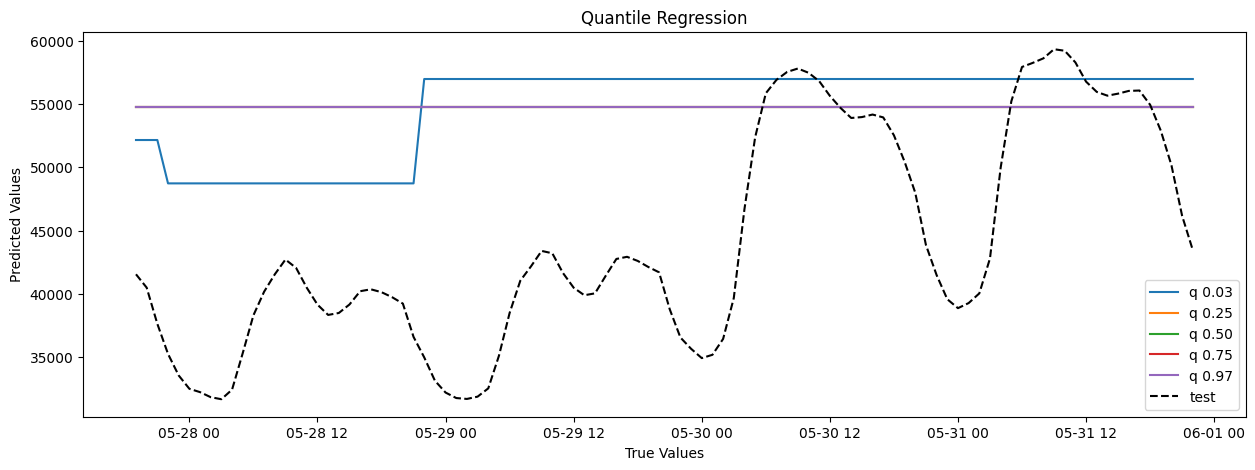

In [7]:
# Plotting for Quantile Regression

plt.figure(figsize=(15, 5))
plt.title(f'Quantile Regression')

for name, quant_reg_model in sorted(all_models_quant_reg.items()):

    y_pred_quant_reg = quant_reg_model.predict(X_test_dummy)
    plt.plot(y_test_dummy.index, y_pred_quant_reg, label=f'{name}')

plt.plot(y_test_dummy.index, y_test_dummy, 'k--', label='test')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


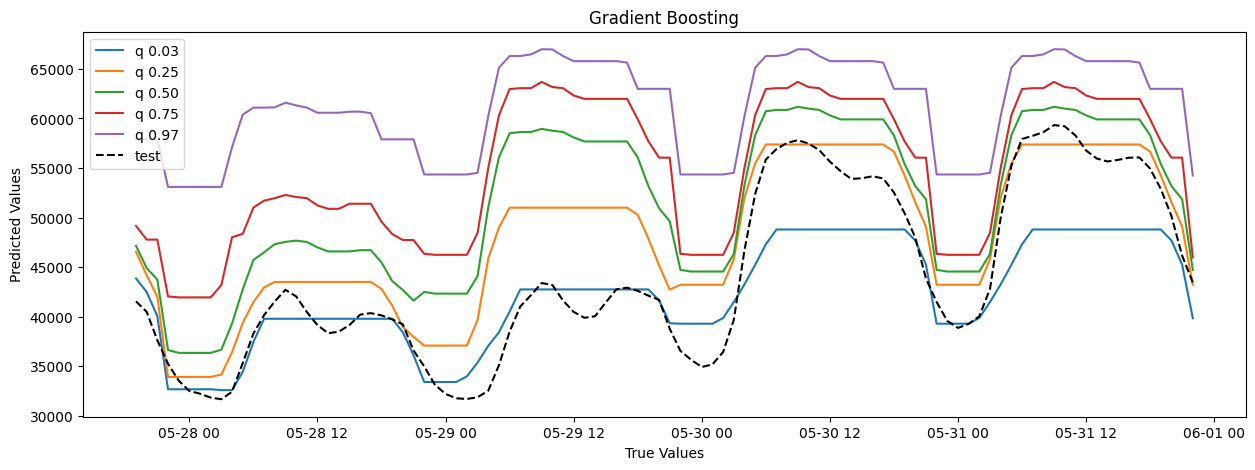

In [10]:
# Plotting for Quantile Regression

plt.figure(figsize=(15, 5))
plt.title(f'Gradient Boosting')

for name, grad_boost_model in sorted(all_models_grad_boost.items()):

    y_pred_grad_boost = grad_boost_model .predict(X_test_fturs)
    plt.plot(y_test_fturs.index, y_pred_grad_boost, label=f'{name}')

plt.plot(y_test_fturs.index, y_test_fturs, 'k--', label='test')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()
